# Navigation

---

Implement Deep Q Network for the Banana Collector environment using the Unity ML-Agents toolkit 

The program has 3 parts :
- Part 1 Defines the classes, initiates the environment and so forth. It sets up all the scaffolding needed
- Part 2 Explore and Learn - it performs the DQN Reinforcement Learning. It also saves the best model
- Part 3 Run saved model
- I have captured portion of the runs in the file p1_nav-02.m4v. So one can run the mp4 file to see how the agent behaves.

So one can either :
- Run the cells in Part 1 and then Part 2 -> to train a model, explore hyperparameters and so forth
- `Or` 
- Run cells in Part 1 and then Part 3 -> to run a stored model

## Part 1 - Definitions & Setup

### 1.1. Install the required packages

The required setup is detailed in the README.md

I am running this on a MacBookPro 14,3 

### 1.2. Define imports

python 3, numpy, matplotlib, torch

In [1]:
# General imports
import numpy as np
import random
from collections import namedtuple, deque

import time
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
%matplotlib inline

# torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
# Constants Definitions
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network
# Number of neurons in the layers of the Q Network
FC1_UNITS = 16
FC2_UNITS = 8
FC3_UNITS = 4
# Store models flag. Store during calibration runs and do not store during hyperparameter search
STORE_MODELS = False

The unity environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

`Note : The file_name might be different for different OS. As mentioned earlier, I am running OSX on a MAcBookPro`

In [3]:
from unityagents import UnityEnvironment
env = UnityEnvironment(file_name="Banana.app") #, no_graphics=True)

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 1.3. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

- The cell below tests to make sure the environment is up and running by printing some information about the environment.
- It also acquires the dimensions of the state and action space

In [4]:
# reset the environment for training agents via external python API
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 1.4. Define classes and setup

The device declaration enables the program leverage GPUs if they are available

In [5]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Not used as we are using only the CPU for this project

### 1.5. Learning Algorithm

We are using the Deep Q Network Algorithm. 

The major components of the algorithm are:
1. `A function approximator` implemented as a Deep Neural Network whih consists of fully connected layers. The function approximator learns the Q values for all the actions for a state space. The banana environment has a state space of 37 and an action space of 4. So out network has an inputsize of 37 and an output size of 4. The accompanying Report.pdf has details on the network architecture.
2. `Experience replay buffer` - in order to train the network we take actions and then store the results in the replay buffer. The replay buffer is a circular buffer and it has methods to sample a random batch
3. `The Agent` brings all of the above together. It interacts with the environment by taking actions based on a policy, collects rewards and the observation feedback, then stores the experience in the replay buffer and also initiates a learning step on the Q Network. The accompanying Report.pdf has more details on the agent.

In [6]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units = FC1_UNITS, fc2_units = FC2_UNITS, fc3_units = FC3_UNITS):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcx_units : Number of units in each layer
            ToDo : It is a little klugy, as the network is built manually layer-by-layer.
                Should take in a list fc_units and then dynamically build the network
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size,fc1_units)
        self.fc2 = nn.Linear(fc1_units,fc2_units)
        self.fc3 = nn.Linear(fc2_units,fc3_units)
        self.fc4 = nn.Linear(fc3_units,action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [7]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float()
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long()
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float()
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float()
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float()
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [8]:
class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed)
        self.qnetwork_target = QNetwork(state_size, action_size, seed)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # compute and minimize the loss
        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states
        Q_targets = rewards + gamma * Q_targets_next * (1 - dones)
        
        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1,actions)
        
        # Compute Loss
        loss = F.mse_loss(Q_expected,Q_targets)
        
        #Minimize Loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

# 1.6. Instantiate an agent

The state space and the action space dimensions come from the environment

In [9]:
agent = Agent(state_size=state_size, action_size=action_size, seed=42)
print(agent.qnetwork_local)

QNetwork(
  (fc1): Linear(in_features=37, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=4, bias=True)
  (fc4): Linear(in_features=4, out_features=4, bias=True)
)


## Part 2 - Learn & Train
-----
#### `Note : If you want to run a stored model, skip Part 2 and run the cells in Part 3 below`

### 2.1. DQN Algorithm

Define the DQN Algorithm. Once we have defined the foundations (network, buffer, agent and so forth), the DQN is relatively easy. It has a few responsibilities:
1. Orchastrate the episodes calling the appropriate methods
2. Display a running commentry of the scores and episode count
3. Check the success criterion for solving the environment i.e. if running average is > 13 and print the episode count
4. Store the model with the maximum score
5. Keep track of the scores for analytics at the end of the run

In [10]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    has_seen_13 = False
    max_score = 0
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]            # get the current state 
        score = 0
        max_steps = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            # next_state, reward, done, _ = env.step(action)
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0] 
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            max_steps += 1
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode : {}\tAverage Score : {:5.2f}\tMax_steps : {}\teps : {:5.3f}\tMax.Score : {:5.3f}'.\
              format(i_episode, np.mean(scores_window),max_steps,eps,max_score), end="")
        if i_episode % 100 == 0:
            print('\rEpisode : {}\tAverage Score : {:5.2f}\tMax_steps : {}\teps : {:5.3f}\tMax.Score : {:5.3f}'.\
                  format(i_episode, np.mean(scores_window),max_steps,eps,max_score))
        if (np.mean(scores_window)>=13.0) and (not has_seen_13):
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:5.2f}'.\
                  format(i_episode-100, np.mean(scores_window)))
            # torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            has_seen_13 = True
            # break
            # To see how far it can go
        # Store the best model if desired
        if STORE_MODELS:
            if np.mean(scores_window) > max_score:
                max_score = np.mean(scores_window)
                torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
                # print(' .. Storing with score {}'.format(max_score))
    return scores

### 2.2. The actual training Run

1. Run the DQN
2. Calculate and display end-of-run analytics viz. descriptive statistics and a plot of the scores

Episode : 100	Average Score :  1.78	Max_steps : 300	eps : 0.005	Max.Score : 0.000
Episode : 200	Average Score :  8.04	Max_steps : 300	eps : 0.005	Max.Score : 0.000
Episode : 300	Average Score : 12.58	Max_steps : 300	eps : 0.005	Max.Score : 0.000
Episode : 309	Average Score : 13.01	Max_steps : 300	eps : 0.005	Max.Score : 0.000
Environment solved in 209 episodes!	Average Score: 13.01
Episode : 400	Average Score : 15.05	Max_steps : 300	eps : 0.005	Max.Score : 0.000
Episode : 500	Average Score : 14.55	Max_steps : 300	eps : 0.005	Max.Score : 0.000
Episode : 600	Average Score : 14.38	Max_steps : 300	eps : 0.005	Max.Score : 0.000
Episode : 700	Average Score : 15.32	Max_steps : 300	eps : 0.005	Max.Score : 0.000
Episode : 800	Average Score : 14.83	Max_steps : 300	eps : 0.005	Max.Score : 0.000
Episode : 900	Average Score : 15.23	Max_steps : 300	eps : 0.005	Max.Score : 0.000
Episode : 1000	Average Score : 15.42	Max_steps : 300	eps : 0.005	Max.Score : 0.000
Elapsed : 0:24:41.908608
2018-10-01 21:4

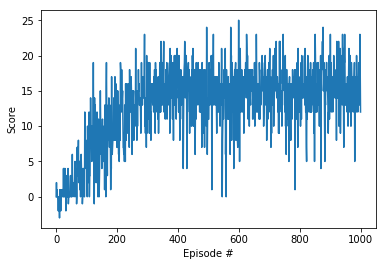

QNetwork(
  (fc1): Linear(in_features=37, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=4, bias=True)
  (fc4): Linear(in_features=4, out_features=4, bias=True)
)
Max Score 25.000000 at 599
Percentile [25,50,75] : [10. 14. 17.]
Variance : 31.916


In [11]:
start_time = time.time()
scores = dqn(n_episodes=1000,eps_end=0.005, eps_decay=0.85) 
# The env ends at 300 steps. Tried max_t > 1K. Didn't see any complex adaptive temporal behavior
env.close() # Close the environment
print('Elapsed : {}'.format(timedelta(seconds=time.time() - start_time)))
print(datetime.now())
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()
print(agent.qnetwork_local)
print('Max Score {:2f} at {}'.format(np.max(scores), np.argmax(scores)))
print('Percentile [25,50,75] : {}'.format(np.percentile(scores,[25,50,75])))
print('Variance : {:.3f}'.format(np.var(scores)))

In [ ]:
### Run Logs and notes as we tweak the parameters
#### A place to keep the statistics and qualitative observations
'''
Max = 2000 episodes, 
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

fc1:64-fc2:64-fc3:4 -> 510 episodes, Max 26 @ 1183 episodes, Runnimg 100 mean 16.25 @1200, @1800 
    Elapsed : 1:19:28.997291

fc1:32-fc2:16-fc3:4 -> 449 episodes, Max 28 @ 1991 episodes, Runnimg 100 mean 16.41 @1300, 16.66 @1600, 17.65 @2000  
    Elapsed : 1:20:27.390989
    Less Variance ? Overall learns better & steady; keeps high scores onc it learned them - match impedence
    percentile[25,50,75] = [11. 15. 18.]; var = 30.469993749999997

fc1:16-fc2:8-fc3:4 -> 502 episodes, Max 28 @ 1568 episodes, Runnimg 100 mean 16.41 @1400, 16.23 @1500, 16.32 @1600  
    Elapsed : 1:18:33.396898
    percentile[25,50,75] = [10. 14. 17.]; var = 30.15840975
    Very calm CPU ! Embed in TX2 or raspberry Pi environment - definitely this network
    Doesn't reach the highs of a larger network

fc1:32-fc2:16-fc3:8-fc4:4 -> 405 episodes, Max 28 @ 1281 episodes, Runnimg 100 mean 17.05 @1500, 16.69 @1700  
    Elapsed : 1:24:07.507518
    percentile[25,50,75] = [11. 15. 18.]; var = 34.83351975
    Back to heavy CPU usage. Reaches solution faster, so definitely more fidelity. Depth gives early advantage

fc1:64-fc2:32-fc3:16-fc4:8-fc5:4 -> 392 episodes, Max 27 @ 631 episodes, Runnimg 100 mean 16.94 @1500  
    Elapsed : 1:17:21.398181
    percentile[25,50,75] = [11. 15. 18.]; var = 31.014
    Higher CPU usage. Reaches solution more faster, so definitely more fidelity. Depth gives early advantage
    But takes longer to train ie get to the same point as the less deep networks. 
    Didn't get to the max score as others ie > 17
    Monstrous atrocity w.r.t the problem we are solving!
    
fc1:32-fc2:4-> 492 episodes, Max 27 @ 1580 episodes, Runnimg 100 mean 16.73 @1900  
    Elapsed : 1:14:06.276599
    percentile[25,50,75] = [10. 14. 17.]; var = 33.485
    Minimalist

Final Model:
fc1:16-fc2:8-fc3:4 -> 567 episodes, Max 27 @ 1535 episodes, Runnimg 100 mean 16.41 @1400, 16.1 @1500
    Elapsed : 1:21:45.714247
    percentile[25,50,75] = [ 9. 14. 17.]; var = 31.137
    Very calm CPU ! I like this, based on my autonomous car and drone background !!
    Occam's Razor and law of parsimony applies here - Optimum Model

Discount Factor = 0.85, Episodes = 1000 (for faster iteration)
10/1/18 : Solved in 852 episodes. It needs a larger discount rate

smaller and faster eps eps_end=0.001, eps_decay=0.85
reaches 0.001 in ~50 episodes
the eps_end is more important
solved in 203 episodes ! Much faster to solve, might not be good for larger action spaces as well as probabilistic spaces
same again !

eps_end = 0.005
solved in 209 episodes. 0.005 is good
Max Score 25.000000 at 599
Percentile [25,50,75] : [10. 14. 17.]
Variance : 31.983

'''

### 2.3. Test Area

In [13]:
print(np.percentile(scores,[25,50,75]))
print(np.var(scores))

[11. 15. 18.]
34.83351975


In [13]:
print(agent.qnetwork_local)

QNetwork(
  (fc1): Linear(in_features=37, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=4, bias=True)
)


In [19]:
print('Max Score {:2f} at {}'.format(np.max(scores), np.argmax(scores)))
len(scores)
np.median(scores)

Max Score 26.000000 at 1183


14.0

In [3]:
# Work area to quickly test utility functions
import time
from datetime import datetime, timedelta
start_time = time.time()
time.sleep(10)
print('Elapsed : {}'.format(timedelta(seconds=time.time() - start_time)))
print(datetime.now())

Elapsed : 0:00:10.001248
2018-10-01 19:06:26.478484


In [12]:
env.close()

## Part 3 : Run a stored Model

### Note
Here we are saving and loading the state dict, because wee have access to the code.

The best way to save and load model, to be used by 2 distinct and separate entities is to :
- `torch.save(model, filepath)`; 
- Then later, `model = torch.load(filepath)`

But, for now, this is not recommended since pytorch is still undergoing a lot of changes. Once Torch 1.0 is released, this might be the best option 

In [10]:
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

In [11]:
scores=[]
for i in range(10): # 10 episodes
    env_info = env.reset(train_mode=False)[brain_name] # reset the environment
    state = env_info.vector_observations[0]            # get the current state
    score = 0                                          # initialize the score
    while True:
        action = agent.act(state)                      # select an action
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished
        score += reward                                # update the score
        state = next_state                             # roll over the state to next time step
        if done:                                       # exit loop if episode finished
            break
    scores.append(score)
    print("Episode {:2d} Score {:5.2f}".format(i+1,score))
print('Mean of {} episodes = {}'.format(i+1,np.mean(scores)))
print(datetime.now())
env.close()

Episode  1 Score 12.00
Episode  2 Score 11.00
Episode  3 Score 15.00
Episode  4 Score 15.00
Episode  5 Score 18.00
Episode  6 Score 16.00
Episode  7 Score 18.00
Episode  8 Score 18.00
Episode  9 Score 16.00
Episode 10 Score 11.00
Mean of 10 episodes = 15.0
2018-10-01 21:15:43.115171
